In [10]:
%load_ext autoreload
%autoreload 2

# qddynamics package Tutorial

This package is for analyzing quantum dot lasing dynamics in a Baysian framework.  It has objects for defining priors, the model, and doing Baysian parameter estimation with emcee. For more information, please see the following papers:

DOI: 10.1515/nanoph-2020-0382

DOI: 10.1073/pnas.1415464111

## Model Definition

Our theoretical model is the solution set to a set of three rate equations (see below). In this model, as is described in [1], it is assumed that carriers are injected into a quantum dot laser via a quantum well and then are subsequently captured by quantum dots for radiative recombination. These coupled rate equations relate Photon Density, Quantum Dot occupation probability, and Carrier Density in the quantum well:

$$
\dot{S} = -\frac{S}{\tau_s} + g_0v(2\rho-1)S \tag{1}
$$

$$
\dot{\rho} = -\frac{\rho}{\tau_d} - g_0(2\rho-1)S + F(N,\rho) \tag{2}
$$

$$
\dot{N} = J - \frac{N}{\tau_n} - 2N_dF(N,\rho) \tag{3}
$$

Where S is photon density; N is carrier density in the quantum well; $\rho$ is the occupation probability in a quantum dot; $\tau_s$ is the photon lifetime; $\tau_n$ and $\tau_d$ are the carrier lifetimes in the well and the dot, respectively; $N_d$ is the 2D density of Quantum Dots, and J is the pump current density. $g_0 = \sigma_{res}v_g$, where $\sigma_{res}$ is the cross section of interaction of carriers in the dots with photons; $v_g$ is the group velocity; and $v = 2N_d\Gamma/d$, where $\Gamma$ is the confinement factor and $d$ is the thickness of the dot layer.

Additionally,

$$
F(N,\rho) = R_{cap}(1-\rho)-R_{esc}\rho \tag{4}
$$

Where $R_{cap} = CN^2 + BN$. C describes Auger carrier capture while B describes carrier-phonon capture. $R_{esc}$ is the rate of escape of carriers from quantum dots and is a temperature dependent function. 

By solving equations 1-3 in steady state, we can define S, $\rho$, and N in terms of input current, or J. Therefore, the S function in terms of J is essentially your "lasing curve". This curve will be what we are "fitting" our data to, as this is the format our data is in. 

When taking lasing curves on our devices, there is a gaussian distribution of noise with standard deviation X units, which will be our likelihood. This noise is generated from a variety of experimental parameters, including stage drift, different spatial excitations of the cavities, and variations in gain media composition across samples. Additionally, we will be assuming a flat prior for our C coefficient, or the Auger capture rate, and a flat prior for our Nd parameter, or the density of quantum dots. Therefore, our statistical model will be:

$$
y_i = Normal(\mu, \sigma)
$$

$$
\mu = Steady\hspace{1mm}state\hspace{1mm}solution\hspace{1mm}of\hspace{1mm}photon\hspace{1mm}number\hspace{1mm}to\hspace{1mm}equations\hspace{1mm}1-3
$$

$$
C \simeq Uniform(10^{-21}, 10^{-19})m^4/s
$$

$$
N_d \simeq Uniform(10^{13}, 10^{15})m^{-2}
$$

So our likelihood function will be:

$$
\mathcal{L} = \prod_{i}^{N} \frac{1}{\sqrt{2\pi\sigma_{yi}^2}}\exp\left({\frac{\left[-y_i - \mu_i(x_i)\right]^2}{2\sigma_{yi}^2}}\right)
$$

where $\mu_i(x_i)$ is the photon number (or "S") solution of the steady state rate equations at various input current densities, $x_i$. From this model, we can infer 2 parameters, the C coefficient and Nd value, for our minimal proof-of-concept goal. The C coefficient is useful for helping quantify specific carrier capture mechanisms and the Nd coefficient is useful as we are never fully aware of the density of quantum dots in our lasers. This density fluctuates within and across fabricated wafers, and therefore it is a fluctuating value in each microdisk laser (as each microdisk is very small i.e. 1um in diameter). Future iterations of this will involve inference of more parameters.

Additionally, we will only be focusing in the regime after lasing threshold is reached. This is because the solutions to the rate equations are stable in this regime. Additionally, an analysis in this regime is more appropriate from a physical perspective, as light emission is dominated by quantum dots above threshold (and this model only assumes one radiatively emitting gain material). 

## Demonstration of model

### Standard Imports

In [1]:
from numpy import exp
import emcee
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
from scipy.optimize import fsolve
from qddynamics.inference.model import JefferysPrior, UniformPrior, LogLikelihood, Posterior
from qddynamics.io import get_example_data_file_path, load_data

### Example of likelihood and posterior calculation using a Uniform Prior

Here we upload our simulation data. This data follows directly from the solution to equations 1-3 in steady state, using O'Brien's values for all of the constants/parameters. Therefore, when we perform inference on the data, the C value should be 10E-20 $\frac{m^4}{s}$, which is exactly what O'Brien et. al. assume in their paper. Additionally, Nd should be 2E15 $\frac{QDs}{m^2}$. Note this is the same format our experimental data will be in, as we collect light output intensity at various input powers only at our lasing wavelength (which is extracted from PL spectra). 

#### We import our data as a pandas dataframe

<AxesSubplot:xlabel='current density (A/m^2)', ylabel='photon density (m^-3)'>

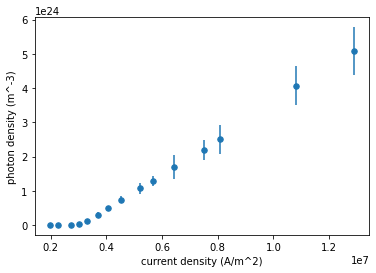

In [2]:
import pandas as pd

simulated_data_frame = load_data(get_example_data_file_path('..\data_files\experimental_data_csv.csv'))

#x = simulated_data_frame['x'][:]
#y = simulated_data_frame['y'][:]
#sigma_y = simulated_data_frame['sigma_y'][:]

## USE FOR EXPERIMENTAL DATASET
x = simulated_data_frame['x'][4:]
y = simulated_data_frame['y'][4:]
sigma_y = simulated_data_frame['sigma_y'][4:]
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
sigma_y.reset_index(drop=True, inplace=True)

simulated_data_frame.columns = ['current density (A/m^2)', 'photon density (m^-3)', 'sigma_y']
simulated_data_frame.plot(x='current density (A/m^2)', y='photon density (m^-3)', kind='scatter', yerr='sigma_y', s=30)

#plt.savefig('figures\simulated_dat.png')

### We can now estimate our paramters through our Posterior probability class.  Let's set up our sampler:

The model has 2 parameters; we'll use 50 walkers and 500 steps each.  The number of walkers and steps default to 50 and 500 respectively

In [3]:
nwalkers = 50
nsteps = 1000

We have to give our mdel an initial guess: here's an initial guess slightly off from the paper's parameter values to show how the MCMC equilibrates to the correct value

In [8]:
ls_result = [1e-20, 1e14, 1.66706437178e-08] 

We also need to set up our priors for Nd and C:

In [5]:
C_bounds = (1e-21, 1e-19)
Nd_bounds = (1e13, 1e15)
g0_bounds = (1.6e-9, 1.6e-7)
CNg0_exp = (1e-20, 1e14, 1.6E-8)

We first set up our posterior class with our initial guess for our constants and bounds on our parameters:

In [6]:
initial_guess = np.array([1E22,0.5,1E15])
logpost = Posterior(initial_guess, C_bounds, Nd_bounds,g0_bounds, CNg0_exp)

Now, we can run our MCMC Chain.  This will call our log posterior (accounting for our priors on our parameters) and call the likelihood of our data

C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Done


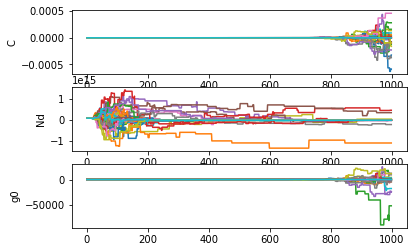

In [7]:
param = logpost.mc(x,y,sigma_y, ls_result)

And we can plot our KDE of our two parameters by calling the plot_parameters function

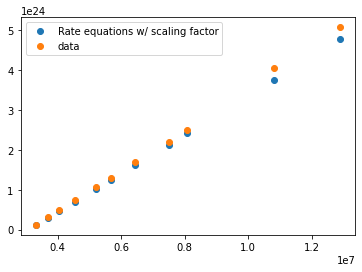

In [9]:
scaling_factor = 1E2

S_out = []
p_out = []
N_out = []

o = 0

zGuess = initial_guess

test=LogLikelihood(ls_result, x, y, sigma_y, zGuess)

fout = lambda ip: fsolve(test.rateEquations, zGuess, args = ip)
z = np.array(list(map(fout, x)))

S_out = z[:,0]*scaling_factor
p_out = z[:,1]
N_out = z[:,2]

plt.plot(x, S_out, 'o', label='Rate equations w/ scaling factor')
plt.plot(x,y, 'o', label='data')
plt.legend()

C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:

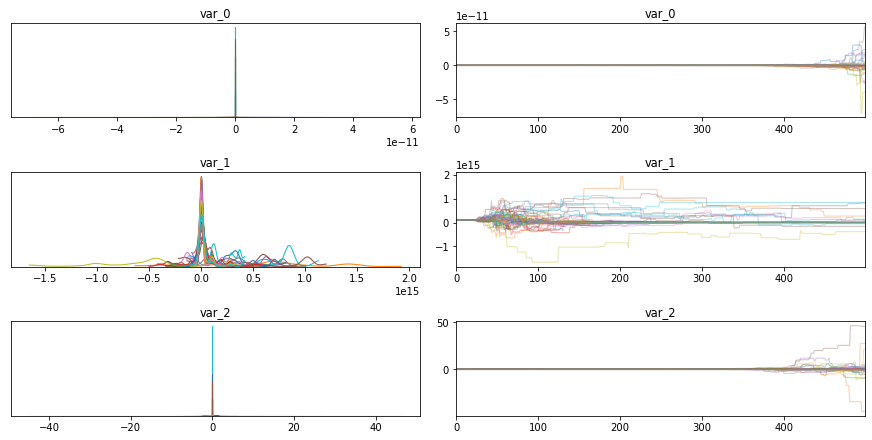

In [8]:
#logpost.plot_parameters(param)
#plt.savefig('figures\sim_est.png')
az.plot_trace(param[1]);

## Results

We can now extract our parameters by calling the extract_paramters function within our Posterior class.  This function uses pandas to concisely calculate the MAP values using quantiles.

In [10]:
parameters = logpost.extract_parameters(param[0])

C = 9.98e-21 + 1.27e-21 - 2.88e-21
Nd = 9.96e+14 + 1.22e+13 - 6.22e+14
g0 = 1.20e-08 + 3.17e-08 - 3.83e-08


### References
1. O’Brien, D., Hegarty, S.P., Huyet, G. and Uskov, A.V., 2004. Sensitivity of quantum-dot semiconductor lasers to optical feedback. Optics letters, 29(10), pp.1072-1074.